# Lotka Volterra using Omega

This notebook is based off https://github.com/devonjkohler/Causal_Inference_Project, a graduate project for the class Casual Modeling in Machine Learning taught by Dr Robert Ness at Northeastern University.

In [1]:
## Load Packages
using Omega
using StatsBase
using Random
using Plots
using Distributions
using PyCall
using DataStructures

┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1192
┌ Warning: Module JSON with build ID 28048663874804 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192
rec_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\stackwalk.c:94
record_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:246
jl_throw at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:577
jl_bounds_error_ints at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64

## Build Model

#### Random Variables

In [71]:
function get_hazards(rng, n, theta)
    
    """
    Compute the hazard function given the current states. "spawn_prey" represents 
    the event of a prey being born, "prey2pred" represents a predator consuming 
    a new prey and consequently spawning a new predator, "pred_dies" represents 
    the death of a predator. The function probabilistically selects one of these 
    based on their weights.
    
    args:
        rng: julia base random number generator, do not need to explicitly pass
        n(int): An index to the current step in prey and pred lists. Used to pull
                most recent values for calculations
    """
    
    ecology = OrderedDict("prey" => prey_list[n](rng), "pred" => pred_list[n](rng), "time" => time_list[n](rng))
    
    hazards = OrderedDict(
        "spawn_prey" => theta["spawn_prey"] * ecology["prey"],
        "prey2pred" => theta["prey2pred"] * ecology["prey"] * ecology["pred"],
        "pred_dies" => theta["pred_dies"] * ecology["pred"]
        )

    vals = collect(values(hazards))
    sum_vals = sum(vals)
    prob_vals = vals/sum_vals
    hazard_result = categorical(rng, prob_vals)
    
    return hazard_result, sum_vals
end

function one_simulation_prey(rng, n, transitions, prey_vals)

    """
    Simulates one step of gillespie for prey. Takes generated hazards
    adds it to prey and outputs the new value.
    
    args:
        rng: julia base random number generator, do not need to explicitly pass
        n(int): An index to the current step in prey and pred lists. Used to pull
                most recent values for calculations
        transitions: Matrix that determines how much prey/pred should change based
                    on selected hazard
    """

    hazard_result = hazards_list[n](rng)
    transition = transitions[hazard_result[1]]

    new_prey = prey_vals[n] + transition[1]
    new_prey = max(1, new_prey)
    push!(prey_vals, new_prey)
    
    return new_prey

end

function one_simulation_pred(rng, n, transitions, pred_vals)

    """
    Simulates one step of gillespie for pred. Takes generated hazards
    adds it to pred and outputs the new value.
    
    args:
        rng: julia base random number generator, do not need to explicitly pass
        n(int): An index to the current step in prey and pred lists. Used to pull
                most recent values for calculations
        transitions: Matrix that determines how much prey/pred should change based
                    on selected hazard
    """

    hazard_result = hazards_list[n](rng)
    transition = transitions[hazard_result[1]]

    new_pred = pred_vals[n] + transition[2]
    new_pred = max(1, new_pred)
    push!(pred_vals, new_pred)
    return new_pred
end

function time_gen(rng, n, time_vals)
    
    """
    Updates the time variable. Takes sum of hazards and samples from exponential function.
    
    args:
    rng: julia base random number generator, do not need to explicitly pass
    n(int): An index to the current step in prey and pred lists. Used to pull
            most recent values for calculations
    """
    hazard_result = hazards_list[n](rng)
    haz_sum = hazard_result[2]
    time_val = time_vals[n] + exponential(rng, haz_sum)
    push!(time_vals, time_val)
    return time_val
end

function reaction_gen(rng, n)
    
    """
    Updates the reaction variable.
    
    args:
    rng: julia base random number generator, do not need to explicitly pass
    n(int): An index to the current step in prey and pred lists. Used to pull
            most recent values for calculations
    """
    
    hazard_result = hazards_list[n](rng)
    t = hazard_result[1]
    return t
end


reaction_gen (generic function with 1 method)

#### Wrapper model function

In [145]:
function omega_simulation(theta, transition, starting_species, N_steps, seed, intervention = false)
    
    ## Initialize lists to hold random variables and species values
    global prey_list = Any[]; global pred_list = Any[]
    global time_list = Any[]; global hazards_list = Any[];
    global reaction_list = Any[]
    
    global prey_vals = []; global pred_vals = []; 
    global time_vals = []; global hazards_vals = []
    global reaction_samples = Any[]
    
    ## Insert starting species values
    insert!(prey_list, 1, uniform([starting_species["prey"]]))
    push!(prey_vals, starting_species["prey"])
    insert!(pred_list, 1, uniform([starting_species["pred"]]))
    push!(pred_vals, starting_species["pred"])
    insert!(time_list, 1, uniform([0]))
    push!(time_vals, 0)
    
    ## Create random variables for each step
    for f in 2:N_steps
        last = f - 1
        push!(hazards_list, ciid(get_hazards, last, theta))
        push!(reaction_list, ciid(reaction_gen, last))
        push!(prey_list, ciid(one_simulation_prey, last, transition, prey_vals))
        push!(pred_list, ciid(one_simulation_pred, last, transition, pred_vals))
        push!(time_list, ciid(time_gen, last, time_vals))
    end
    
    ## Insert intervention if needed
    tracker = Dict("prey" => prey_list, "pred" => pred_list, "reaction" => reaction_list)
    if intervention != false
        for x in 1:length(intervention)
            intervention_temp = intervention[x]
            intervene_list = tracker[intervention_temp[1]]
            intervene_list[intervention_temp[2]] = replace(intervene_list[intervention_temp[2]], 
                intervene_list[intervention_temp[2]] => intervention_temp[3])
        end
    end

    ## Sample
    Random.seed!(seed)
    samples = rand(Tuple(reaction_list), 1, alg = RejectionSample)
    
    ## Get species trace
    prey_trace = Any[]
    push!(prey_trace, starting_species["prey"])
    pred_trace = Any[]
    push!(pred_trace, starting_species["pred"])
    for x in 1:length(samples[1])
        push!(prey_trace, prey_trace[length(prey_trace)] + transition[samples[1][x]][1])
        push!(pred_trace, pred_trace[length(pred_trace)] + transition[samples[1][x]][2])
    end

    ## Return model results
    return samples[1], prey_trace, pred_trace, time_vals
    
end

omega_simulation (generic function with 4 methods)

### Initial Parameters

In [146]:
## Transition Matrix
Pre = [[1, 0], [1, 1], [0, 1]]
Post = [[2, 0], [0, 2], [0, 0]]
t = Post - Pre

species = Dict("prey" => 60., "pred" => 100.)

# Rate Values
spawn_prey = .9
prey2pred = .004
pred_dies = .4

rates =  Dict("spawn_prey" => spawn_prey,
         "prey2pred" => prey2pred,
         "pred_dies" => pred_dies)

Dict{String,Float64} with 3 entries:
  "spawn_prey" => 0.9
  "pred_dies"  => 0.4
  "prey2pred"  => 0.004

## Ground Truth Model

In [147]:
simple_sim = omega_simulation(rates, t, species, 1000, 02)
print()

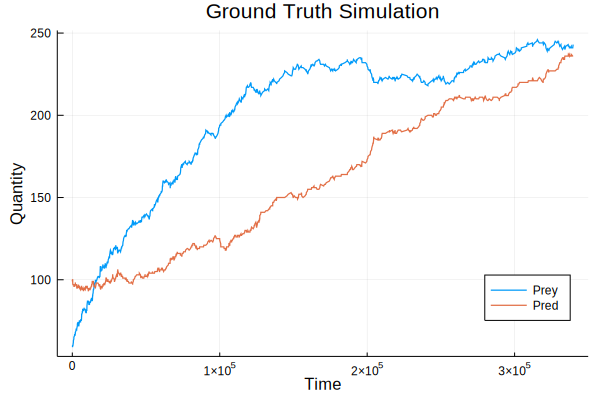

In [148]:
plot(simple_sim[4][1:999], hcat(simple_sim[2][1:999], simple_sim[3][1:999]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Prey" "Pred"],
        lw = 1.25,
        legend = :bottomright)

Here we ran a simple Gillespie simulation of Lotka-Volterra with a set seed.

## Intervention

In [149]:
int_sim = omega_simulation(rates, t, species, 1000, 02, [("reaction", 500, 3), ("reaction", 501, 3), 
                                                         ("reaction", 502, 3), ("reaction", 503, 3), 
                                                         ("reaction", 504, 3), ("reaction", 505, 3), 
                                                         ("reaction", 506, 3), ("reaction", 507, 3), 
                                                         ("reaction", 508, 3), ("reaction", 509, 3)])
print()

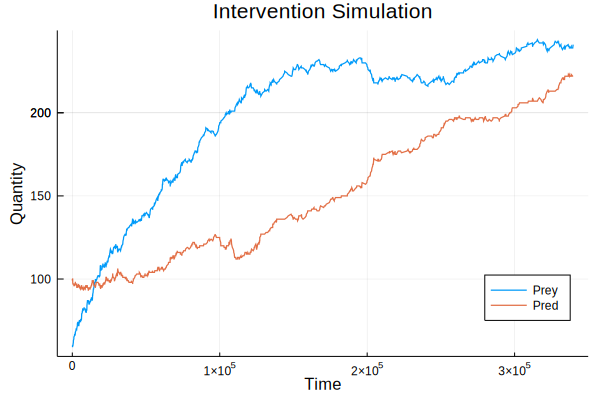

In [150]:
plot(int_sim[4][1:999], hcat(int_sim[2][1:999], int_sim[3][1:999]),
        title = "Intervention Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Prey" "Pred"],
        lw = 1.25,
        legend = :bottomright)

In this simulation we intervened at reaction 500 to 509 and set the transition to be "predator dies" we can see this in the trace, with the predator trace decreasing around time 100000. We set the same seed in this intervention so the exogenous variables should be the same in both simulations.

## Conditioned Intervention

Ideally, we would be able to treat the first simulation, without an intervention, as experimental (or observed data). We would condition on this observed data to infer the exogenous variables, as real world data does not have a simple seed we can set. Once conditioned we should be able to intervene on the trace and ask counterfactuals.

To do this we need to update our simulation wrapper function to include an option for conditioning.

In [151]:
function omega_simulation(theta, transition, starting_species, N_steps, seed, condition_vals, intervention = false)
    
    ## Initialize lists to hold random variables and species values
    global prey_list = Any[]; global pred_list = Any[]
    global time_list = Any[]; global hazards_list = Any[];
    global reaction_list = Any[]
    
    global prey_vals = []; global pred_vals = []; 
    global time_vals = []; global hazards_vals = []
    global reaction_samples = Any[]
    
    ## Insert starting species values
    insert!(prey_list, 1, uniform([starting_species["prey"]]))
    push!(prey_vals, starting_species["prey"])
    insert!(pred_list, 1, uniform([starting_species["pred"]]))
    push!(pred_vals, starting_species["pred"])
    insert!(time_list, 1, uniform([0]))
    push!(time_vals, 0)
    
    ## Create random variables for each step
    for f in 2:N_steps
        last = f - 1
        push!(hazards_list, ciid(get_hazards, last, theta))
        push!(reaction_list, ciid(reaction_gen, last))
        
        temp_prey = ciid(one_simulation_prey, last, transition, prey_vals)
        push!(prey_list, cond(temp_prey, temp_prey ==ₛ condition_vals["prey"][f]))
        
        temp_pred = ciid(one_simulation_pred, last, transition, pred_vals)
        push!(pred_list, cond(temp_pred, temp_pred ==ₛ condition_vals["pred"][f]))
        
        push!(time_list, ciid(time_gen, last, time_vals))
    end
    
    ## Insert intervention if needed
    tracker = Dict("prey" => prey_list, "pred" => pred_list, "reaction" => reaction_list)
    if intervention != false
        for x in 1:length(intervention)
            intervention_temp = intervention[x]
            intervene_list = tracker[intervention_temp[1]]
            intervene_list[intervention_temp[2]] = replace(intervene_list[intervention_temp[2]], 
                intervene_list[intervention_temp[2]] => intervention_temp[3])
        end
    end

    ## Sample
    Random.seed!(seed)
    samples = rand(Tuple(reaction_list), 1, alg = Replica)
    
    ## Get species trace
    prey_trace = Any[]
    push!(prey_trace, starting_species["prey"])
    pred_trace = Any[]
    push!(pred_trace, starting_species["pred"])
    for x in 1:length(samples[1])
        push!(prey_trace, prey_trace[length(prey_trace)] + transition[samples[1][x]][1])
        push!(pred_trace, pred_trace[length(pred_trace)] + transition[samples[1][x]][2])
    end

    ## Return model results
    return samples[1], prey_trace, pred_trace, time_vals
    
end

omega_simulation (generic function with 4 methods)

In [152]:
condition_sim = omega_simulation(rates, t, species, 1000, 10, Dict("prey" => simple_sim[2], "pred" => simple_sim[3]))
print()

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]
plast = -0.00040184457138424254
plast = -8.902426827195885
plast = -195760.0
plast = -4.310248959056761e9


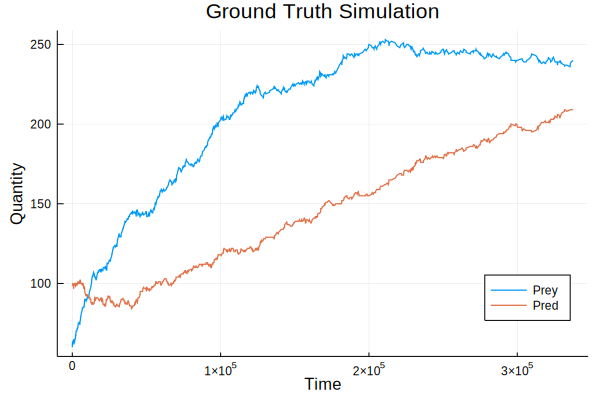

In [153]:
plot(condition_sim[4][1:999], hcat(condition_sim[2][1:999], condition_sim[3][1:999]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Prey" "Pred"],
        lw = 1.25,
        legend = :bottomright)

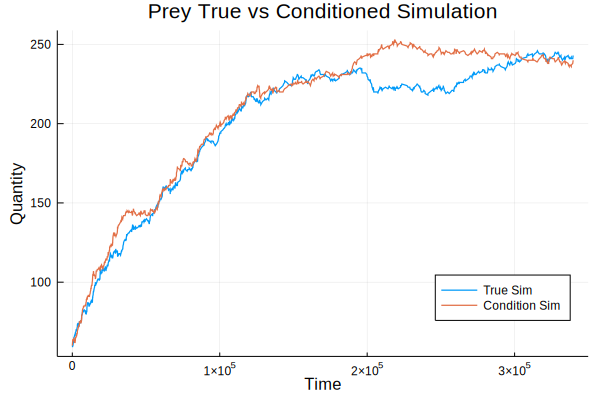

In [154]:
plot(simple_sim[4][1:999], hcat(simple_sim[2][1:999], condition_sim[2][1:999]),
        title = "Prey True vs Conditioned Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["True Sim" "Condition Sim"],
        lw = 1.25,
        legend = :bottomright)

The traces appear to be reasonably close until we reach the end of the simulation where they start to diverge. In order to get an accurate answer to our counterfactual we need to learn the real exogenous variables as close as possible.

There are parameters we can tune, in particular the temperatures used by the Replica sampling algorithm, to try and get the conditioned and true traces closer.

For now lets continue with the analysis using the conditioned trace above. We will make the same intervention as before.

In [156]:
condition_int_sim = omega_simulation(rates, t, species, 1000, 10, Dict("prey" => simple_sim[2], "pred" => simple_sim[3]),
    [("reaction", 500, 3), ("reaction", 501, 3), 
     ("reaction", 502, 3), ("reaction", 503, 3), 
     ("reaction", 504, 3), ("reaction", 505, 3), 
     ("reaction", 506, 3), ("reaction", 507, 3), 
     ("reaction", 508, 3), ("reaction", 509, 3)])
print()

temps = [2.06115e-9, 4.53999e-5, 1.0, 22026.5]
plast = -0.00040184457138424254
plast = -8.902426827195885
plast = -195760.0
plast = -4.310248959056761e9


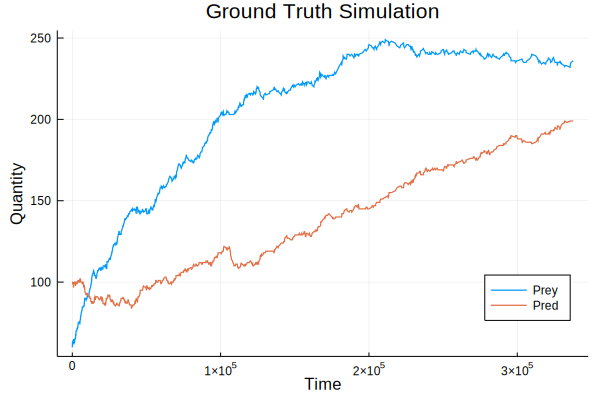

In [158]:
plot(condition_int_sim[4][1:999], hcat(condition_int_sim[2][1:999], condition_int_sim[3][1:999]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["Prey" "Pred"],
        lw = 1.25,
        legend = :bottomright)

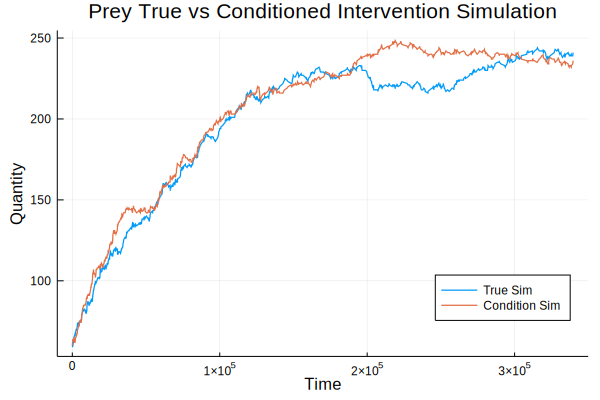

In [159]:
plot(int_sim[4][1:999], hcat(int_sim[2][1:999], condition_int_sim[2][1:999]),
        title = "Prey True vs Conditioned Intervention Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["True Sim" "Condition Sim"],
        lw = 1.25,
        legend = :bottomright)


Again the intervened traces appear to be reasonably close until we reach the end of the simulation where they start to diverge. The final trace values are fairly close. We need to focus on tuning the conditioning algorithm to ensure the most accurate results.